<a href="https://colab.research.google.com/github/youssef1232004/Deep-learning-project-/blob/main/MobileNetV2_in_cat_and_dog_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/cat-dog-images-for-classification
License(s): CC0-1.0
100% 544M/545M [00:30<00:00, 21.7MB/s]
100% 545M/545M [00:30<00:00, 18.5MB/s]


In [ ]:
# Basic
import os
from os import listdir
import numpy as np
import pandas as pd
import zipfile

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Specify the path to the zip file containing the dataset and the extraction location
train_file_path = "/content/cat-dog-images-for-classification.zip"  # Replace with the actual path to the dataset zip file
files = "/content"  # Replace with the path to the folder where files will be extracted

# Open the zip file and extract all its contents
with zipfile.ZipFile(train_file_path, 'r') as zip_file:
    zip_file.extractall(files)  # Extract files to the specified folder

In [ ]:
# Specify the directory containing the images
image_dir = "/content/cat_dog"  # Replace with the path to the folder containing images

# Get a list of filenames (images) in the directory
filenames = os.listdir(image_dir)  # Replace with the image folder variable

# Extract the label for each image by splitting the filename at the dot (.) and taking the first part (e.g., 'cat.jpg' -> 'cat')
labels = [x.split(".")[0] for x in filenames]  # For example, if the filename is 'cat.jpg', the label will be 'cat'

# Create a Pandas DataFrame with two columns: 'filename' and 'label'
data = pd.DataFrame({"filename": filenames, "label": labels})

# Display the first five rows of the DataFrame to ensure the data has been read correctly
data.head()

,filename,label
0,dog.3376.jpg,dog
1,dog.11573.jpg,dog
2,dog.2401.jpg,dog
3,cat.7875.jpg,cat
4,dog.3271.jpg,dog


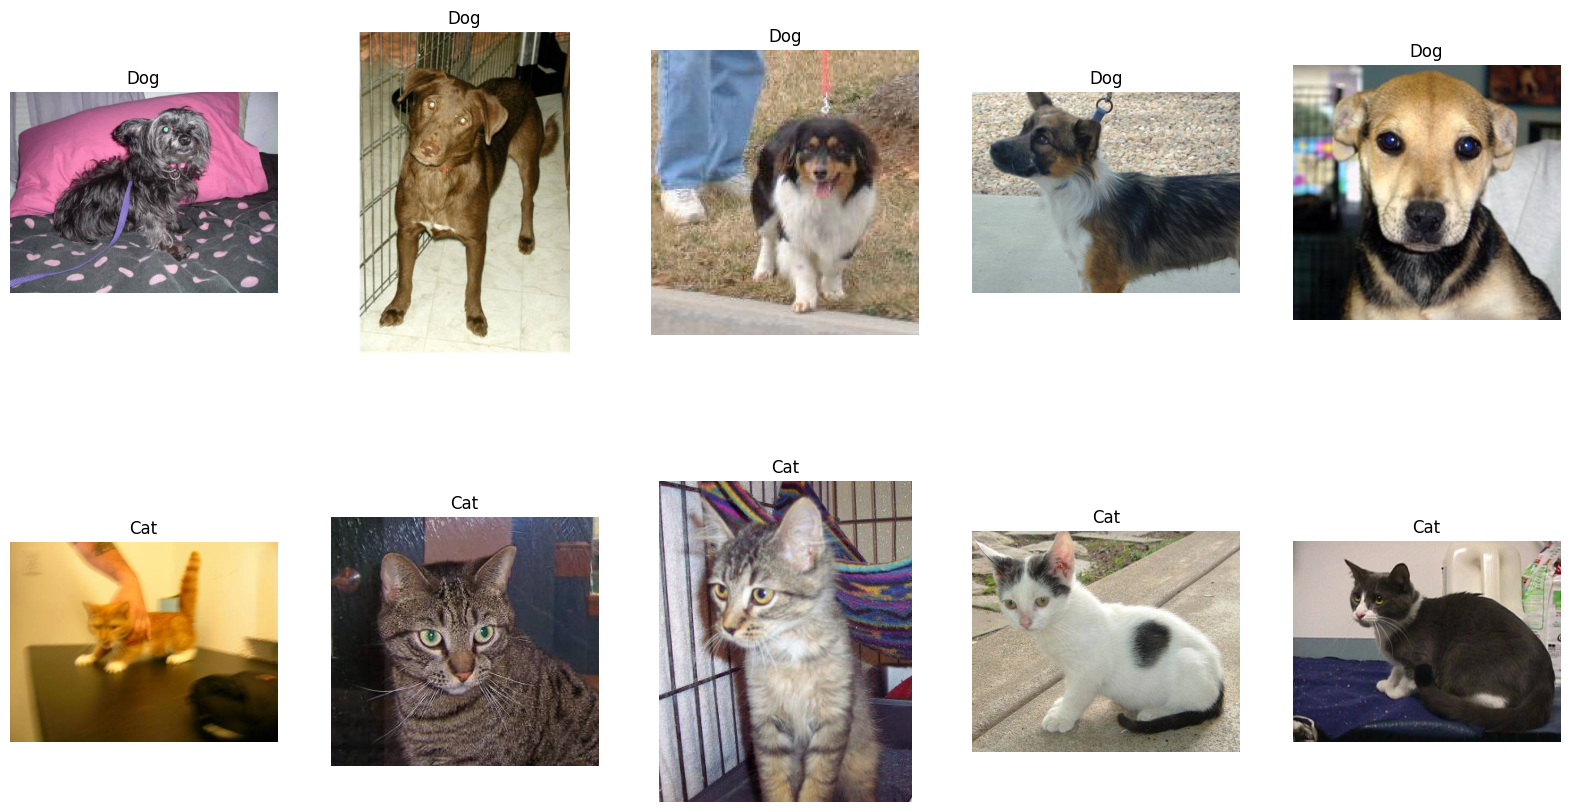

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.4)

# Displaying Dog and Cat Images
for i, label in enumerate(['dog', 'cat']):
    for j in range(5):
        # Subplot layout and image loading
        plt.subplot(2, 5, i * 5 + j + 1)  # Define position in the grid
        # Updated filename to include the correct path and directory separator
        filename = os.path.join(image_dir, f'{label}.{j}.jpg')  # Build filename using os.path.join
        image = imread(filename)          # Load the image using imread function

        # Displaying the image
        plt.imshow(image)
        plt.title(label.capitalize(), fontsize=12)  # Display label with capitalization
        plt.axis('off')                             # Hide axes for cleaner visualization

plt.show()

In [ ]:

# Split data into training (70%) and test (30%) sets
X_train, X_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)



# Print the shapes of the resulting datasets
print('The shape of train data', X_train.shape)
print('The shape of test data', X_test.shape)


The shape of train data (20000, 2)
The shape of test data (5000, 2)


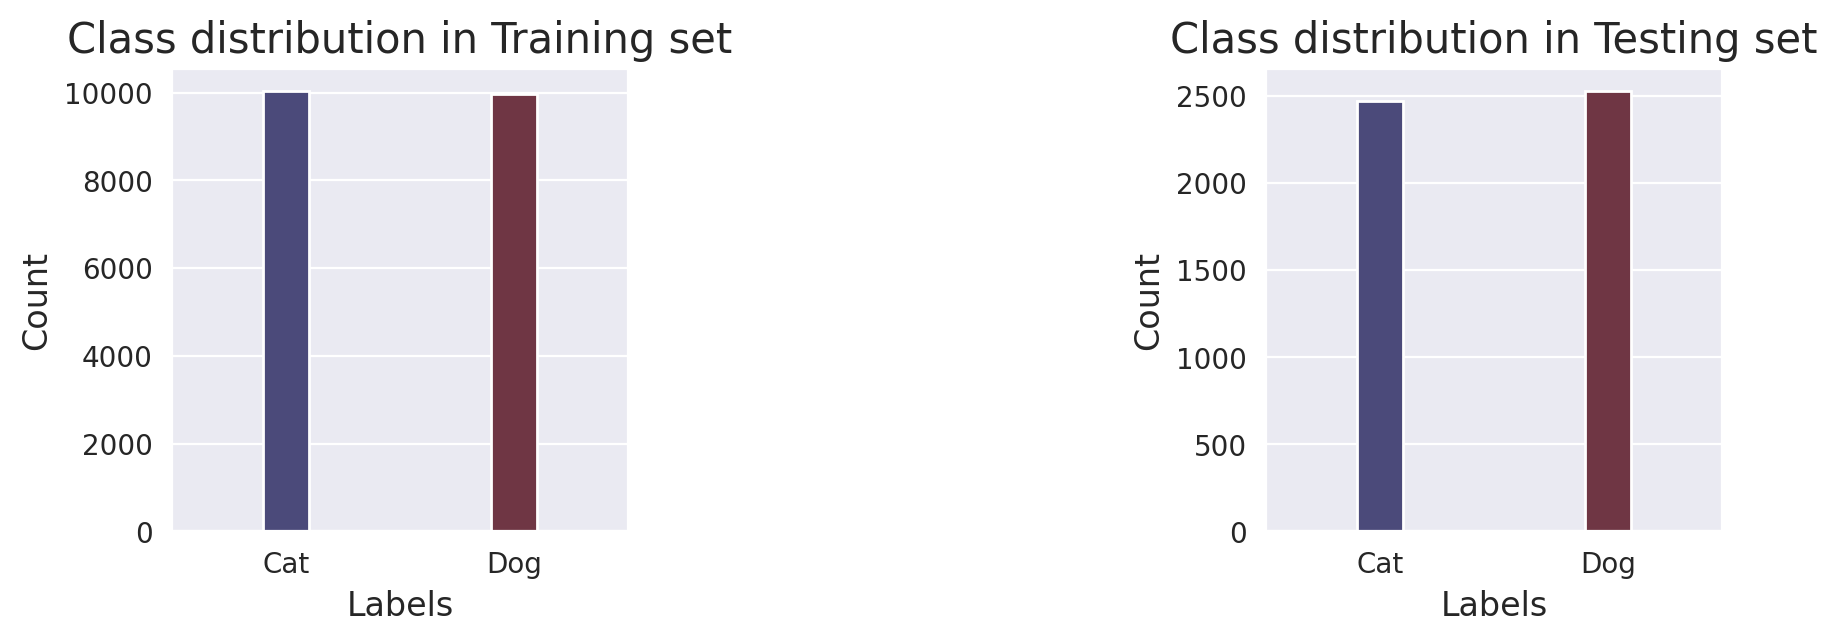

In [ ]:
labels = ['Cat','Dog']

label1,count1 = np.unique(X_train.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)

uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])


plt.figure(figsize=(10,3),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()

In [ ]:
image_size = (224, 224)# Image size
image_channel = 3 # Number of color channels
batch_size = 32  # Batch size for training the model



In [ ]:
# Create ImageDataGenerator for training with image augmentation
train_datagen = ImageDataGenerator(rescale=1./255,  # Normalize image pixels to the range 0-1
                                    rotation_range=40,  # Random rotation of images
                                    horizontal_flip=True,  # Flip images horizontally
                                    zoom_range=0.2,  # Random zoom on images
                                    shear_range=0.2,  # Random shear transformation on images
                                    fill_mode='nearest',  # Method to fill empty pixels after transformations
                                    width_shift_range=0.2,  # Random horizontal shift of images
                                    validation_split=0.2,
                                    height_shift_range=0.2)  # Random vertical shift of images

# Create ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)  # Normalize image pixels to the range 0-1 for testing


In [ ]:
train_generator = train_datagen.flow_from_dataframe(dataframe=X_train,  # Use the training split
                                                    directory=image_dir,  # Directory containing images
                                                    x_col='filename',  # Column containing image filenames
                                                    y_col='label',  # Column containing image labels
                                                    batch_size=batch_size,  # Batch size for training
                                                    class_mode='binary',
                                                    shuffle=True,
                                                    subset='training',
                                                    target_size=image_size)  # Resize images to target size

val_generator = train_datagen.flow_from_dataframe(dataframe=X_train,  # Use the validation split
                                                 directory=image_dir,  # Directory containing images
                                                 x_col='filename',  # Column containing image filenames
                                                 y_col='label',  # Column containing image labels
                                                 batch_size=batch_size,  # Batch size for validation
                                                 class_mode='binary',
                                                  shuffle=True,
                                                  subset='validation',
                                                 target_size=image_size)  # Resize images
test_generator = test_datagen.flow_from_dataframe(
    dataframe=X_test,
    directory=image_dir,
    x_col='filename',
    y_col='label',  # Ensure 'label' column has numerical data (0/1)
    shuffle=False,
    batch_size=batch_size,
    target_size=image_size,
    class_mode='binary'  # Ensure this is set for binary classification
)

Found 16000 validated image filenames belonging to 2 classes.
Found 4000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Load the MobileNetV2 model with pre-trained weights from ImageNet
pretrained_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the pre-trained layers to retain the features learned
for layer in pretrained_model.layers:
    layer.trainable = False

# Add new custom layers on top of the MobileNetV2 backbone
x = layers.GlobalAveragePooling2D()(pretrained_model.output)
x = layers.Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)  # Binary classification output (Cat vs. Dog)

# Define the final model
model = Model(inputs=pretrained_model.input, outputs=x)

# Compile the model with the Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',  # Correct loss for binary classification
    metrics=['accuracy']
)

# Add callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("cats_dogs_model.keras", save_best_only=True)



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├──────────────────────

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 281s 535ms/step - accuracy: 0.8867 - loss: 3.7364 - val_accuracy: 0.9640 - val_loss: 1.8528
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 296s 586ms/step - accuracy: 0.9585 - loss: 1.5750 - val_accuracy: 0.9665 - val_loss: 0.9345
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 269s 532ms/step - accuracy: 0.9608 - loss: 0.8318 - val_accuracy: 0.9643 - val_loss: 0.5485
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 350s 590ms/step - accuracy: 0.9587 - loss: 0.5047 - val_accuracy: 0.9575 - val_loss: 0.3727
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 289s 524ms/step - accuracy: 0.9626 - loss: 0.3371 - val_accuracy: 0.9653 - val_loss: 0.2557
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 513ms/step - accuracy: 0.9635 - loss: 0.2486 - val_accuracy: 0.9657 - val_loss: 0.2022
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 259s 510ms/step - accuracy: 0.9664 - loss: 0.1956 - val_accuracy: 0.9655 - val_loss: 0.1642
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 289s 569ms/step - accuracy: 0.9665 -

In [ ]:
# Retrieve final training accuracy and loss
train_acc = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Training Loss: {train_loss:.4f}")
#Validation set Accuracy
val_acc = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")

# Evaluate the model on the testing set using the test_generator
test_loss, test_acc = model.evaluate(test_generator)  # Use test_generator instead of test_images
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Testing Loss: {test_loss:.4f}")

Final Training Accuracy: 0.9634
Final Training Loss: 0.1161
Final Validation Accuracy: 0.9670
Final Validation Loss: 0.1051
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 93ms/step - accuracy: 0.9773 - loss: 0.0868
Testing Accuracy: 0.9766
Testing Loss: 0.0840


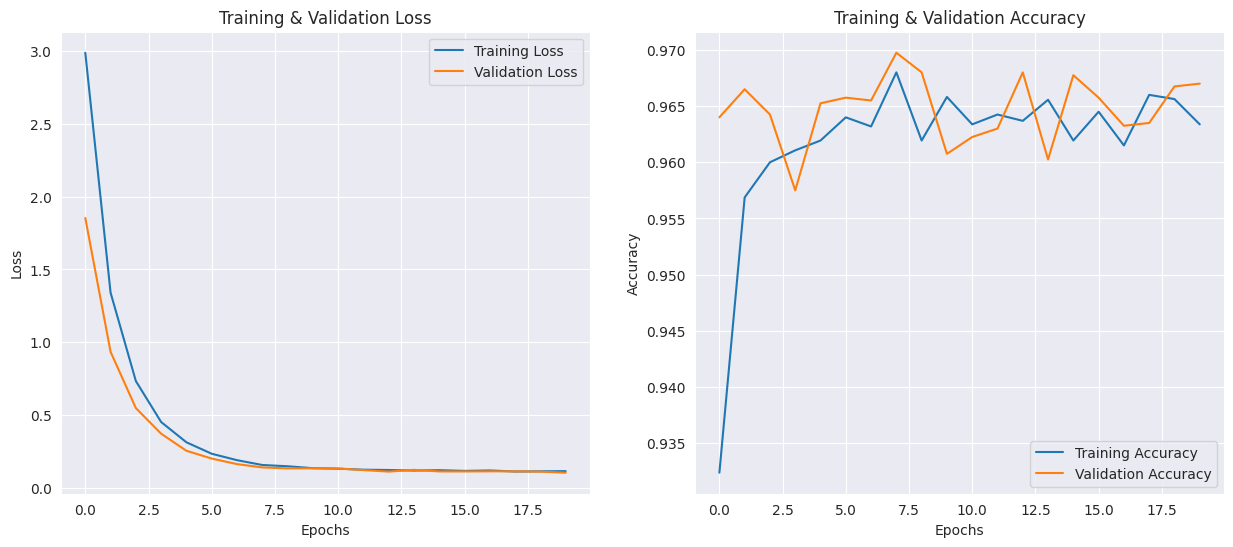

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'history' is the training history object with the required data
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Get the number of epochs (length of the training history data)
epochs = range(len(loss))

# Create the subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot training and validation loss
ax[0].plot(epochs, loss, label='Training Loss')
ax[0].plot(epochs, val_loss, label='Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

# Plot training and validation accuracy
ax[1].plot(epochs, accuracy, label='Training Accuracy')
ax[1].plot(epochs, val_accuracy, label='Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

# Show the plots
plt.show()

In [ ]:
# Assuming you have 'test_generator' defined from a previous cell
pred = model.predict(test_generator)

# Get the true labels from the test generator
true_labels = test_generator.classes

# Get the predicted labels (0 or 1)
pred_labels = (pred > 0.5).astype(int)  # Assuming 0.5 as the threshold for binary classification

# Map the predicted labels to class names ('Cat' or 'Dog')
labels = (train_generator.class_indices)  # Get class indices from train_generator
labels = dict((v,k) for k,v in labels.items())  # Invert the dictionary
pred_classes = [labels[k[0]] for k in pred_labels]
# Display the result
print(f'The first 10 predictions: {pred_classes[:10]}')

157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step
The first 10 predictions: ['dog', 'dog', 'dog', 'cat', 'cat', 'cat', 'dog', 'dog', 'dog', 'dog']


157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step


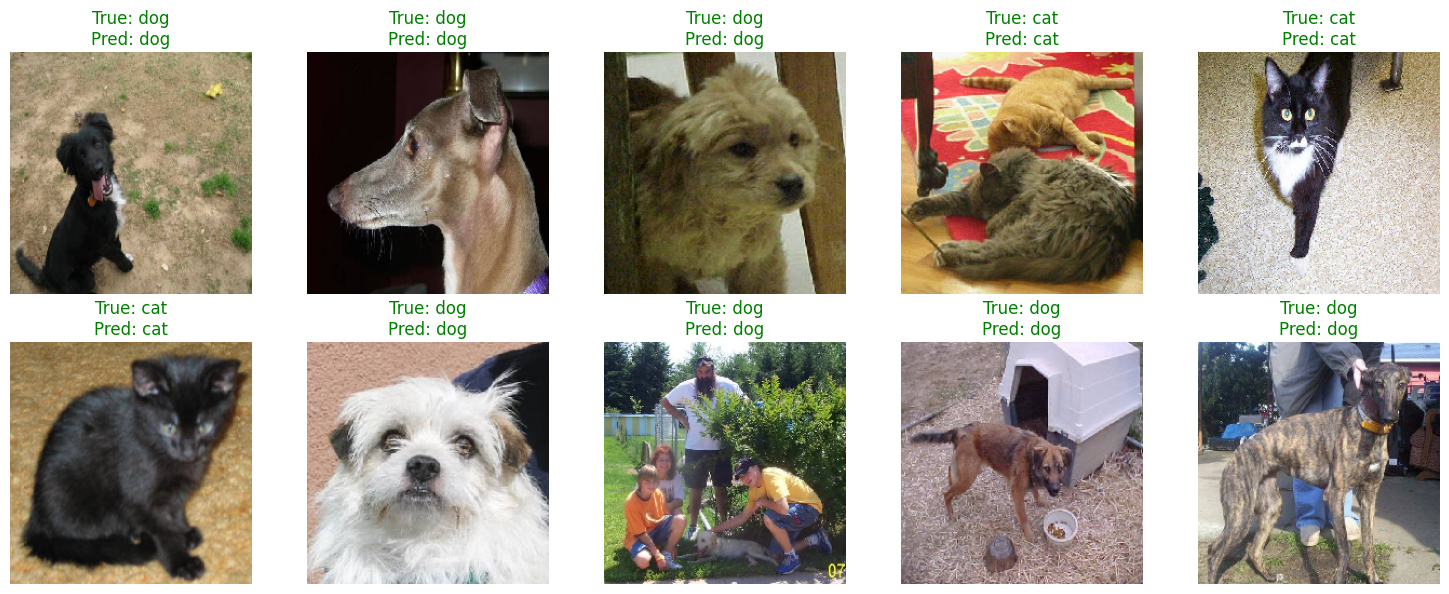

In [ ]:
import matplotlib.pyplot as plt


# Assuming you have 'test_generator' defined from a previous cell
pred = model.predict(test_generator)
pred_labels = (pred > 0.5).astype(int)


# Get a batch of images and labels from the test generator
images, true_labels_batch = next(test_generator)  # Get a batch of data

# Select a subset of images to display (e.g., the first 10)
num_images_to_display = 10
images_to_display = images[:num_images_to_display]
true_labels_to_display = true_labels_batch[:num_images_to_display]  # True labels for displayed images
pred_labels_to_display = pred_labels[:num_images_to_display]  # Predicted labels for displayed images
pred_classes_to_display = pred_classes[:num_images_to_display] # Predicted classes for displayed images


# Create a figure and subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 rows, 5 columns for 10 images
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through the images and plot them with predictions
for i, ax in enumerate(axes):
    ax.imshow(images_to_display[i])
    ax.axis('off')  # Hide axes

    # Get the true and predicted labels for the current image
    true_label = true_labels_to_display[i]  # Get true numerical label
    pred_label = pred_labels_to_display[i][0] # Get predicted numerical label

    #Map to class name
    true_class = labels[true_label]
    pred_class = labels[pred_label]
    # Set the title with true and predicted labels
    ax.set_title(f"True: {true_class}\nPred: {pred_class}", color='green' if true_label == pred_label else 'red')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [ ]:
y_test = list(X_test.label) # X_test DataFrame has a 'label' column, not 'Label'
report = classification_report(y_test, pred_classes, output_dict=True) # pred_classes maps prediction to class names
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
cat,0.989203,0.963203,0.976030,2473.0000
dog,0.964892,0.989711,0.977144,2527.0000
accuracy,0.976600,0.976600,0.976600,0.9766
macro avg,0.977047,0.976457,0.976587,5000.0000
weighted avg,0.976916,0.976600,0.976593,5000.0000


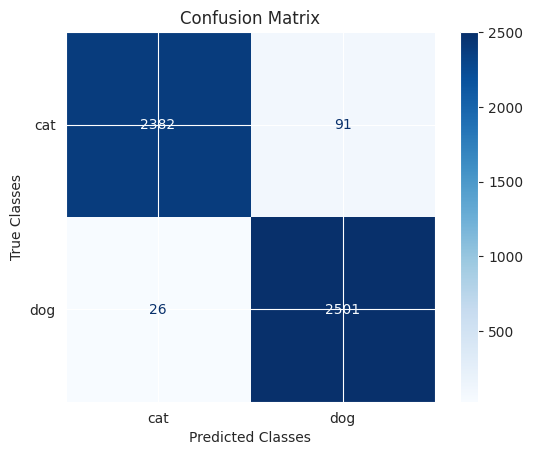

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming y_test and pred are defined
# Convert y_test to numerical labels (0 for 'cat', 1 for 'dog')
y_test_numeric = [0 if label == 'cat' else 1 for label in y_test]

# Convert pred to binary predictions (0 or 1) using a threshold
pred_binary = (pred > 0.5).astype(int)  # You can adjust the threshold if needed

# Now, create the confusion matrix
cm = confusion_matrix(y_test_numeric, pred_binary)

# Define your class names (matching the numerical labels)
class_names = ['cat', 'dog']

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Change the color to blue
disp.plot(cmap='Blues')

plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.title('Confusion Matrix')

plt.show()